<a href="https://colab.research.google.com/github/Ayra-Hossain/Breast_Cancer_BUSI/blob/main/Dataset_BUSI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/Dataset_BUSI_with_GT

Mounted at /content/drive
/content/drive/MyDrive/Dataset_BUSI_with_GT


# Installations


In [ ]:
!pip install --upgrade tensorflow

# Imports

In [ ]:
import os
import shutil
import random
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Rename the images (remove extra spaces and brackets)

In [ ]:
import os
import re

# Define the dataset path
dataset_path = '/content/drive/MyDrive/Dataset_BUSI_with_GT/dataset/'

# Function to rename images and masks
def rename_files_in_category(category):
    # Define paths for images and masks
    image_folder = os.path.join(dataset_path, category, category)
    mask_folder = os.path.join(dataset_path, category, 'masked')

    # Rename images
    for filename in os.listdir(image_folder):
        match = re.match(rf'{category} \((\d+)\)\.png', filename)
        if match:
            number = match.group(1)
            new_filename = f'{category}_{number}.png'
            old_file_path = os.path.join(image_folder, filename)
            new_file_path = os.path.join(image_folder, new_filename)
            os.rename(old_file_path, new_file_path)
            # print(f'Renamed image: {old_file_path} to {new_file_path}')

    # Rename masks
    for filename in os.listdir(mask_folder):
        match = re.match(rf'{category} \((\d+)\)_mask\.png', filename)
        if match:
            number = match.group(1)
            new_filename = f'{category}_{number}_mask.png'
            old_file_path = os.path.join(mask_folder, filename)
            new_file_path = os.path.join(mask_folder, new_filename)
            os.rename(old_file_path, new_file_path)
            # print(f'Renamed mask: {old_file_path} to {new_file_path}')

# Categories to process
categories = ['benign', 'malignant', 'normal']

# Process each category
for category in categories:
    rename_files_in_category(category)


# Normalise the dataset

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define ImageDataGenerator with normalization
datagen = ImageDataGenerator(rescale=1.0/255.0)  # Normalize images to [0, 1]

# Train your model using the normalized dataset
train_generator = datagen.flow_from_directory('/content/drive/MyDrive/Dataset_BUSI_with_GT/dataset', target_size=(256, 256), batch_size=32, class_mode='binary')


Found 1561 images belonging to 3 classes.


# Annotate your images for YOLO

In [ ]:
def convert_mask_to_yolo(mask_path, class_id, img_width, img_height, output_txt):
    # Ensure the directory for the output file exists
    os.makedirs(os.path.dirname(output_txt), exist_ok=True)

    # Read the mask
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    if mask is None:
        raise FileNotFoundError(f"Mask image not found: {mask_path}")

    # Find contours in the mask
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    with open(output_txt, 'w') as file:
        # For each contour (each object)
        for contour in contours:
            # Get the bounding box for the contour
            x, y, w, h = cv2.boundingRect(contour)

            # Convert to YOLO format
            x_center = (x + w / 2) / img_width
            y_center = (y + h / 2) / img_height
            width = w / img_width
            height = h / img_height

            # Write the class_id and bounding box to the output file
            file.write(f"{class_id} {x_center} {y_center} {width} {height}\n")
    # print("Mask shape:", mask.shape)

In [ ]:
# Define dataset paths
dataset_path = '/content/drive/MyDrive/Dataset_BUSI_with_GT/dataset'
class_ids = {
    "normal": 0,
    "benign": 1,
    "malignant": 2
}

# Iterate over each class folder
# Iterate over each class folder
for class_name, class_id in class_ids.items():
    class_folder = os.path.join(dataset_path, class_name)
    masked_folder = os.path.join(class_folder, "masked")

    # Create labels folder if it doesn't exist
    os.makedirs(os.path.join(class_folder, "labels"), exist_ok=True)

    # Iterate over all mask files in the masked folder
    for mask_file in os.listdir(masked_folder):
        if mask_file.endswith("_mask.png"):
            mask_path = os.path.join(masked_folder, mask_file)
            # Output file name can be based on mask file name
            output_txt = os.path.join(class_folder, "labels", f"{mask_file[:-9]}.txt")  # Strip the '_mask' part

            # Call the conversion function
            convert_mask_to_yolo(mask_path, class_id, 1024, 768, output_txt)

# Display the bounded region on original image

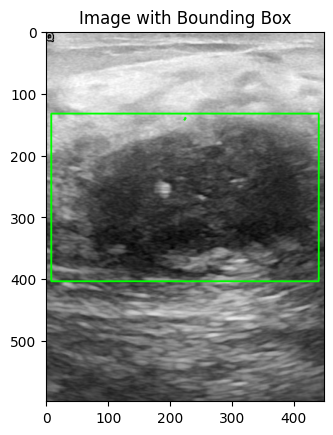

In [ ]:
import cv2
import matplotlib.pyplot as plt

def draw_bounding_box(image_path, txt_file, img_width, img_height):
    # Load the original image
    img = cv2.imread(image_path)
    if img is None:
        print("Image not found")
        return

    # Read YOLO format annotations from the txt file
    with open(txt_file, 'r') as file:
        for line in file:
            class_id, x_center, y_center, width, height = map(float, line.strip().split())

            # Convert normalized YOLO coordinates back to pixel values
            x_center_pixel = x_center * img_width
            y_center_pixel = y_center * img_height
            box_width_pixel = width * img_width
            box_height_pixel = height * img_height

            # Calculate the bounding box corners
            x_min = int(x_center_pixel - (box_width_pixel / 2))
            y_min = int(y_center_pixel - (box_height_pixel / 2))
            x_max = int(x_center_pixel + (box_width_pixel / 2))
            y_max = int(y_center_pixel + (box_height_pixel / 2))

            # Draw the bounding box on the image
            cv2.rectangle(img, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)  # Green box

    # Convert the image to RGB (since OpenCV uses BGR by default)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Display the image with bounding box
    plt.imshow(img_rgb)
    plt.title("Image with Bounding Box")
    plt.show()

# Example usage
image_path = '/content/drive/MyDrive/Dataset_BUSI_with_GT/dataset/malignant/malignant/malignant_1.png'
txt_file = '/content/drive/MyDrive/Dataset_BUSI_with_GT/dataset/malignant/labels/malignant_1.txt'
img_width = 1024  # Actual image width
img_height = 768  # Actual image height

draw_bounding_box(image_path, txt_file, img_width, img_height)

# Split the dataset

In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Define paths
dataset_dir = '/content/drive/MyDrive/Dataset_BUSI_with_GT/dataset'  # Update with your dataset directory
output_dir = '/content/drive/MyDrive/Dataset_BUSI_with_GT/dataset'    # Update with your desired output directory

# Define class folders
classes = ['benign', 'malignant', 'normal']

# Create output directories for train, test, and val splits
for split in ['train', 'test', 'val']:
    for cls in classes:
        os.makedirs(os.path.join(output_dir, split, cls, 'images'), exist_ok=True)
        os.makedirs(os.path.join(output_dir, split, cls, 'labels'), exist_ok=True)

# Function to split and copy data
def split_and_copy_data(class_folder):
    # Paths for images and masks
    images_folder_path = os.path.join(dataset_dir, class_folder, 'benign' if class_folder == 'benign' else class_folder)
    labels_folder_path = os.path.join(dataset_dir, class_folder, 'labels')  # Assuming labels are in 'labels' folder

    # Check if folders exist
    if not os.path.exists(images_folder_path):
        print(f"Images folder not found: {images_folder_path}")
        return
    if not os.path.exists(labels_folder_path):
        print(f"Labels folder not found: {labels_folder_path}")
        return

    # List of image and label files
    image_filenames = os.listdir(images_folder_path)
    label_filenames = os.listdir(labels_folder_path)

    # Split data into train (80%), temp (20%: test + val)
    train_files, temp_files = train_test_split(image_filenames, test_size=0.2, random_state=42)  # 80% train, 20% temp
    val_files, test_files = train_test_split(temp_files, test_size=0.5, random_state=42)  # Split temp into 10% val and 10% test

    # Function to copy files to respective split folders
    def copy_files(files, split):
        for file in files:
            src_image_path = os.path.join(images_folder_path, file)
            dst_image_path = os.path.join(output_dir, split, class_folder, 'images', file)
            shutil.copy(src_image_path, dst_image_path)

            # Copy corresponding label file
            label_file = file[:-4] + '.txt'  # Assuming labels have the same base name as images
            src_label_path = os.path.join(labels_folder_path, label_file)
            dst_label_path = os.path.join(output_dir, split, class_folder, 'labels', label_file)

            # Check if the label file exists before copying
            if os.path.exists(src_label_path):
                shutil.copy(src_label_path, dst_label_path)
            else:
                print(f"Label file not found: {src_label_path}")

    # Copy files to train, test, and val folders
    copy_files(train_files, 'train')
    copy_files(test_files, 'test')
    copy_files(val_files, 'val')

# Loop through each class and split the data
for cls in classes:
    split_and_copy_data(cls)

print("Dataset split and organized successfully.")


Dataset split and organized successfully.


# Implemet the YOLO V8 MODEL

In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 877.5/877.5 kB 24.2 MB/s eta 0:00:00


In [ ]:
from ultralytics import YOLO
from IPython.display import display

# Load the YOLOV8 model
model = YOLO('yolov8n.pt')

!yolo task=detect mode=train model=yolov8n.pt data=/content/drive/MyDrive/Dataset_BUSI_with_GT/dataset/dataset.yaml epochs=100 imgsz=640 plots=True

Ultralytics 8.3.12 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/drive/MyDrive/Dataset_BUSI_with_GT/dataset/dataset.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_

# Validate your model

In [ ]:
!yolo task=detect mode=val model=/content/drive/MyDrive/Dataset_BUSI_with_GT/runs/detect/train/weights/best.pt data=/content/drive/MyDrive/Dataset_BUSI_with_GT/dataset/dataset.yaml

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics 8.3.22 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 186 layers, 2,684,953 parameters, 0 gradients, 6.8 GFLOPs
100% 755k/755k [00:00<00:00, 22.9MB/s]
val: Scanning /content/drive/MyDrive/Dataset_BUSI_with_GT/dataset/val/benign/labels.cache... 78 images, 13 backgrounds, 0 corrupt: 100% 78/78 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 5/5 [00:27<00:00,  5.46s/it]
                   all         78         67      0.315      0.191      0.184     0.0678
                benign         44         46      0.284      0.239      0.179     0.0744
             malignant    

# Predict through Images

In [ ]:
!yolo task=detect mode=predict model=/content/drive/MyDrive/Dataset_BUSI_with_GT/runs/detect/train/weights/best.pt conf=0.125 source=/content/drive/MyDrive/Dataset_BUSI_with_GT/dataset/test/normal/images/normal_125.png

Ultralytics 8.3.22 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 186 layers, 2,684,953 parameters, 0 gradients, 6.8 GFLOPs

image 1/1 /content/drive/MyDrive/Dataset_BUSI_with_GT/dataset/test/normal/images/normal_125.png: 544x640 (no detections), 36.7ms
Speed: 2.8ms preprocess, 36.7ms inference, 25.0ms postprocess per image at shape (1, 3, 544, 640)
Results saved to runs/detect/predict14
💡 Learn more at https://docs.ultralytics.com/modes/predict


In [ ]:
import os
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

# Load your ground truth and predictions here
# This is an example, replace it with your actual loading mechanism
y_true = []  # Fill with your ground truth labels
y_pred = []  # Fill with your model predictions

# Assuming binary classification for simplicity
# You may need to adapt this based on the number of classes
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1score = f1_score(y_true, y_pred)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"f1Score: {f1score:.2f}")
# For mAP calculation
# You may use a specific library or custom function for mAP calculation.
def calculate_map(ground_truth, predictions):
    # Your implementation or use of a library
    pass

# Call your mAP calculation function
# map_value = calculate_map(y_true, y_pred)
# print(f"mAP: {map_value:.2f}")


Precision: 0.00
Recall: 0.00
f1Score: 0.00


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
